In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm

In [2]:
"""
Utility functions and classes for cross species
analysis

@yhr91
"""

from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import spearmanr
import plotly.express as px
import numpy as np
import pandas as pd
import warnings
import scanpy as sc
from sklearn.metrics import adjusted_mutual_info_score, rand_score
from collections import Counter
from scipy.stats import mode
import operator

# --------

class cross_species_acc():
    """
    Class for calculating cross species accuracy metrics
    """

    def __init__(self, adata, base_species='human', 
                 target_species='mouse', label_col='CL_class_coarse', 
                 metric='cosine', medoid=False, space='raw'):

        self.adata = adata
        self.base_species = base_species
        self.target_species = target_species
        self.label_col = label_col
        self.metric = metric
        self.medoid=medoid
        self.space=space
        
        # Calculate accuracy metrics
        self.calc_cross_species_label_matches()

    def find_all_species_centres(self):
        """
        Finds all species-specific centroids given an AnnData object
        """
        if self.space == 'umap':
            key = 'X_umap'
        elif self.space == 'samap':
            key = 'X_umap_samap'
        elif self.space == 'scanorama':
            key = 'X_scanorama'
        elif self.space == 'harmony':
            key = 'X_harmony'
        
        centres = {}
        centres['size'] = {}
        base_cluster_sizes = {}
        for species in self.adata.obs['species'].unique():
            centres[species] = {}
            species_set = self.adata[self.adata.obs['species']==species]
            
            for l in species_set.obs[self.label_col].unique():
                subset = species_set[species_set.obs[self.label_col] == l]
                
                # If space is not raw then use the right obsm column
                if self.space != 'raw':
                    subset_data = subset.obsm[key]
                else:
                    subset_data = subset.X.toarray()

                # Deal with exceptions
                if len(subset)<1:
                    continue
                elif len(subset)==1:
                    centres[species][l] = subset_data[0]
                
                # Use centroid or medoid
                centroid = np.mean(subset_data, 0)
                if self.medoid:
                    centres[species][l] =\
                        self.get_medoid(subset_data, centroid)
                else:
                    centres[species][l] = centroid
                    
                # This is for normalization of distances
                if species == self.base_species:
                    dist_mat = euclidean_distances(subset_data)
                    centres['size'][l] = np.max(dist_mat)
            
        return pd.DataFrame(centres).dropna()

    
    def calc_cross_species_label_matches(self):
        """
        Given Anndata object, returns:
        - matches: number of cluster centres in base species that 
        have the same cluster label in the target species as nn
        - dist: 'normalized' distance between cluster centre of base 
        species and the cluster centre with the same label in target 
        species
        
        TODO: This is not generalized to more than 2 species
        """
        warnings.filterwarnings("ignore")
        
        centres = self.find_all_species_centres()
        dist = 0
        norm_dist = 0
        matches = 0
        matches_names = []
        matches_names_all = []
        target_centres = np.vstack(
                   centres.loc[:,self.target_species].values)
        
        for idx, ctype in enumerate(centres.index):
            base = centres.loc[ctype, self.base_species]
            base_targets = np.vstack([base, target_centres])

            if self.metric=='cosine':
                distances = cosine_distances(base_targets)[0][1:]
                
            pred_match = np.argmin(distances)
            if  pred_match == idx:
                matches += 1
                matches_names.append(ctype)
            
            matches_names_all.append((ctype,
                         centres.index[pred_match]))
            dist += distances[idx]
            norm_dist += distances[idx]/centres.loc[ctype, 'size']

        self.cross_species_label_dist = dist
        self.cross_species_label_norm_dist = norm_dist
        self.cross_species_label_matches = matches
        self.cross_species_label_matches_names = matches_names
        self.cross_species_label_matches_names_all = matches_names_all
        
        warnings.filterwarnings("always")
     
    
    def get_medoid(self, data, centroid):
        dists = euclidean_distances(np.vstack([centroid,data]))[0]
        return data[np.argsort(dists)[1]-1]
        
        
# --------


class embedding_CL_comparison():
    """
    Class for comparing embedding with cell ontology
    """

    def __init__(self, adata, label_col='CL_class_coarse', CL_ID_col='CL_ID_coarse',
                 metric='cosine', features='raw'):

        warnings.filterwarnings("ignore")
        self.adata = adata
        self.label_col = label_col
        self.CL_ID_col = CL_ID_col
        self.metric = metric
        self.features = features
        self.labels = self.adata.obs[self.label_col].unique()
        self.centres = []
        self.centres_ranked = []
        self.CL_centres_ranked = []

        # Get centres, nns and ranks
        self.get_centre_ranks()
        self.get_CL_ranks()

        # Calculate metrics
        self.spearman_corr = {}
        self.hits_at_k = {}
        for id_ in self.labels:         
            self.spearman_corr[id_] = spearmanr(self.CL_centres_ranked[id_], 
                self.centres_ranked[id_])[0]
            self.hits_at_k[id_] = self.get_hits_topk(self.CL_centres_ranked[id_], 
                self.centres_ranked[id_])
            
        warnings.filterwarnings("always")

        
    # Implement cluster centroid

    def find_centre(self, cluster, medioid=False):
        """
        Find cluster centre: either centroid or medioid
        """
        if medioid:
            dist = euclidean_distances(cluster)
            medioid = np.argmin(dist.sum(0))
            return cluster[medioid].toarray()

        else:
            return np.mean(cluster,0)
    
    
    def get_outlier_idx(self, CL_centres, centres, k=10):
        """
        Get top or bottom ranked nn
        """
        outliers = []
        for i, pair in enumerate(list(zip(CL_centres, centres))):
            if pair[0] < k or pair[1] < k:
                outliers.append(i)
        return outliers

    
    def get_hits_topk(self, CL_centres, centres, k=10):
        """
        Get numbers of matches within top k
        """
        return len(set(CL_centres[:k]).intersection(set(centres[:k])))
        

    def get_centre_ranks(self):
        """
        Get nn ranks for cluster centres
        """
        for cell_type in self.labels:
            if self.features=='raw':
                self.centres.append(self.find_centre(
                    self.adata[self.adata.obs[self.label_col] == cell_type].X))
        self.centres = np.vstack(self.centres)
                
        if self.metric=='euclidean':
            centres_dist = euclidean_distances(self.centres)

        if self.metric=='cosine':
            centres_dist = cosine_distances(self.centres)

        self.centres_ranked = {k:v for k,v in zip(
            self.labels, np.argsort(centres_dist))}
        
    def get_CL_ranks(self):
        """
        Get nn ranks for cell ontology cluster centres
        """
        all_CL_distances = pd.read_csv('/dfs/project/cross-species/data/lung/shared/CL_similarity_RW.csv',
                                       index_col=0)

        CL_sim_matrix = all_CL_distances.loc[self.adata.obs[self.CL_ID_col].unique(),
                                             self.adata.obs[self.CL_ID_col].unique()]
        
        ID_dict = self.adata.obs.set_index(self.label_col).to_dict()['CL_ID_coarse']
        inv_ID_dict = {v: k for k, v in ID_dict.items()}

        self.CL_centres_ranked = {inv_ID_dict[k]:v for k,v in zip(self.adata.obs['CL_ID_coarse'].unique(),
                                                           np.argsort(-CL_sim_matrix.values))}

    
    def plot_rank_scatter(self):
        """
        Create rank scatter plot between embedding nn and CL nn
        """
        fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=[20,15])
        it = 0
        spearman_corr = {}
        hits_at_k = {}
        outlier=False

        for i in range(5):
            for j in range(5):
                if it == len(self.labels):
                    break

                id_ = self.labels[it]
                if outlier:
                    outlier_idx = get_outlier_idx(self.CL_centres_ranked[id_], 
                        self.centres_ranked[id_])
                    axs[i, j].scatter(self.CL_centres_ranked[id_][outlier_idx], 
                    self.centres_ranked[id_][outlier_idx])
                else:
                    axs[i, j].scatter(self.CL_centres_ranked[id_], 
                    self.centres_ranked[id_])
                axs[i, j].set_title(id_)
                axs[i, j].plot([0,32],[0,32], 'k')   
                it += 1
                
    def plot_hits_at_k(self):
        plot_df = pd.DataFrame.from_dict(self.hits_at_k, orient='index')
        plot_df = plot_df.rename(columns={0:'Value'})
        plot_df = plot_df.sort_values('Value')

        plt.figure(figsize=[8,12])
        plt.barh(plot_df.index, plot_df['Value'])
        plt.ylabel('Cell Type')
        plt.xlabel('Hits @ k')
        plt.title('Hits @ k (Embedding space compared to Cell Ontology)')
        plt.xlim([0,10])
        
        
    def plot_spearman(self):
        plot_df = pd.DataFrame.from_dict(self.spearman_corr, orient='index')
        plot_df = plot_df.rename(columns={0:'Value'})
        plot_df = plot_df.sort_values('Value')

        plt.figure(figsize=[8,12])
        plt.barh(plot_df.index, plot_df['Value'])
        plt.ylabel('Cell Type')
        plt.xlabel('Spearman Correlation')
        plt.title('Spearman Correlation (Embedding space compared to Cell Ontology)')
        plt.xlim([-1,1])
          
        
# --------

## KNN analysis per cell
## TODO integrate these functions into cross_species_acc class

def get_knn_label(cell_names, adata, col):
    """
    Returns majority class labels of nearest neighbors. 
    Will return random label in case of tie
    """
    
    return adata[cell_names].obs[col].value_counts().index[0]


def cross_species_knn_all(adata, k=1, species='human', space='raw',
                          col = 'cell_type', metric='euclidean',
                          verbose = False, consider_same_species=False):
    """Runs cross species k nearest neighbor on all cells
    """

    # Create distance matrix
    if space == 'raw':
        X = adata.X
    elif space == 'umap':
        X = adata.obsm['X_umap']
    elif space == 'samap':
        X = adata.obsm['X_umap_samap']
    elif space == 'scanorama':
        X = adata.obsm['X_scanorama']
    elif space == 'harmony':
        X = adata.obsm['X_harmony']
    
    # Slow step
    if metric == 'euclidean':
        dist_mat = euclidean_distances(X)
    elif metric == 'cosine':
        dist_mat = cosine_distances(X)
        
    if consider_same_species:
        # Get indices for species and nonspecies cells
        species_idx = np.where(adata.obs['species']==species)[0]
        adata.obs['temp_label'] = adata.obs['species'].astype(str) +\
                            '_' + adata.obs[col].astype(str)

        nns = []
        for idx in species_idx:
            curr_temp_label = adata.obs['temp_label'][idx]
            row = dist_mat[idx,:]
            possible_nbrs = np.where(adata.obs['temp_label'] != curr_temp_label)[0]
            
            row = row[possible_nbrs]
            nns.append(possible_nbrs[np.argpartition(row, k)[:k]])
            
        nbrs = [(adata.obs[col][x], Mode(adata.obs[col][y].astype('str').values)) 
                        for x,y in zip(species_idx, nns)]
    
    else:
        # Get indices for species and nonspecies cells
        species_idx = np.where(adata.obs['species']==species)[0]
        nonspecies_idx = np.where(adata.obs['species'] != species)[0]

        # Slow step
        reduced_dist_mat = dist_mat[species_idx,:][:,nonspecies_idx]
        
        nns = [list(nonspecies_idx[y]) 
               for y in np.argpartition(reduced_dist_mat, k)[:,:k]]

        nbrs = [(adata.obs[col][x], Mode(adata.obs[col][y].astype('str').values)) 
                        for x,y in zip(species_idx, nns)]
    
    return nbrs


def cluster_knn(cluster_knn_df, label):
    """
    Given majority k nearest cross species neigbhor class for each cell, 
    identifies the k nearest neighbors for the given cluster
    """
    
    list_ = list(cluster_knn_df[cluster_knn_df['Source_Cell']==label].
                value_counts().items())
    x = pd.DataFrame([(s[0][1],s[1]) for s in list_])
    x['Source_Cluster'] = list_[0][0][0]
    x = x.rename(columns={0:'Cross_Species_KNN_Label', 1:'Score'})
    x['Score'] = x['Score']/x['Score'].sum()
    return x


def cluster_knn_all(all_nbrs):
    """
    Given majority k nearest cross species neigbhor class for each cell, 
    identifies the k nearest neighbors for all clusters
    """
    cluster_knn_df = pd.DataFrame(all_nbrs)
    cluster_knn_df = cluster_knn_df.rename(columns={0:'Source_Cell',1:'Cross_Species_KNN'})

    return [cluster_knn(cluster_knn_df, c) 
         for c in cluster_knn_df['Source_Cell'].unique()]   


def plot_cluster_knn_bar(df, source='human', other='mouse', ax=None, title=None):
    """
    Creates a stacked bar plot to identify majority k nearest neighbors for
    a given cluster, on a specific axis
    """
    if ax is None:
        fig, (ax) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 17), frameon=False)
    bars = defaultdict(int)
    colors = defaultdict(int)
    tick = -1; 
    tick_pos = {}
    colors_list = ['','r','g','b','y','k','purple','g','b','y','k','g','b','y',
                                                       'k','g','b','y','k',
                                                       'k','g','b','y','k',
                                                       'k','g','b','y','k'] + ["w"]*50
    df = df.sort_values(['Source_Cluster', 'Score'], ascending=False)

    for i in df.iterrows():
        color = 'k'
        x = i[1]['Source_Cluster']
        y = i[1]['Score']        

        if i[1]['Cross_Species_KNN_Label'] == i[1]['Source_Cluster']:
            color= 'w'
        left = bars[x]
        bars[x] = bars[x] + y
        colors[x] = colors[x] + 1
        if colors_list[colors[x]] == 'r':    
            tick = tick+1
            tick_pos[x] = tick
            if bars[x]>=0.25:
                ax.text(0.1,tick-0.2,i[1]['Cross_Species_KNN_Label'], color=color)
        ax.barh(tick_pos[x], y, left=left, color=colors_list[colors[x]], alpha=0.5)
        
    keys = sorted(tick_pos.keys())
    vals = [tick_pos[k] for k in keys]
    ax.set_yticks(vals, keys)
    ax.set_ylabel(source)
    ax.set_xlabel('Percentage of cells with cross-species KNN class')
    if title is not None:
        ax.set_title(title)
    
    return 

## ---------------------------------
## Alignment scores
## -----------------------------------

def alignment_score(fname, col='cell_type', space='raw', k=1,
                    species='human', consider_same_species=False):
    adata = sc.read_h5ad(fname)
    if space=='umap':
        sc.pp.pca(adata, n_comps=50)
        sc.pp.neighbors(adata, n_neighbors=15)
        sc.tl.umap(adata)
    all_nbrs = cross_species_knn_all(adata, col=col, metric='cosine', space=space, k=k,
                                     species=species, consider_same_species=consider_same_species)
    all_cluster_nbrs  = [i for i in cluster_knn_all(all_nbrs)]
    all_cluster_nbrs = pd.concat(all_cluster_nbrs).reset_index(drop=True) 
    return all_cluster_nbrs

def compare_matches(alignments, true_alignments):
    aligns = alignments.merge(true_alignments, on=['Source_Cluster', 'Cross_Species_KNN_Label'])
    #aligns = aligns.merge(true_alignments, on=['Source_Cluster'], how='outer').fillna(0)
    
    return aligns

def score_matches(alignments, true_alignments, thresh=0.5, ret_matches=False):
    matches = compare_matches(alignments, true_alignments)
    if ret_matches:
        return matches[matches['Score']>thresh]
    else:
        return sum(matches['Score']>thresh)
    return

def create_comparison_plot_df(all_cluster_nbrs1, all_cluster_nbrs2, true_map):
    
    knn_scores_1 = compare_matches(all_cluster_nbrs1, true_map)
    knn_scores_2 = compare_matches(all_cluster_nbrs2, true_map)

    plot_df = knn_scores_1.merge(knn_scores_2, on='Source_Cluster') 
    return plot_df

def get_comparison_plot(plot_df, bars=2, labels_=['Method1', 'Method2']):
    plt.figure(figsize=[20,5])
    ax=plt.gca()

    labels = plot_df['Source_Cluster'].values
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    #fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, plot_df['Score_x'].values, width, label=labels_[0])
    if bars == 2:
        rects2 = ax.bar(x + width/2, plot_df['Score_y'].values, width, label=labels_[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% of nearest neighbors of\n correct cross species label')
    ax.set_title('Cross species cell type alignment')
    plt.xticks(x, labels, rotation='vertical')
    ax.set_xticklabels(labels)
    ax.legend() 

    
def get_cell_alignment(align_df, true_df, count_df):
    align_df['Source_Cluster'] = align_df['Source_Cluster'].astype('str')
    count_df['Source_Cluster'] = count_df['Source_Cluster'].astype('str')
    true_df['Source_Cluster'] = true_df['Source_Cluster'].astype('str')
    align_df['Cross_Species_KNN_Label'] = align_df['Cross_Species_KNN_Label'].astype('str')                  
    true_df['Cross_Species_KNN_Label'] = true_df['Cross_Species_KNN_Label'].astype('str')
    
    df = align_df.merge(true_df, on=['Source_Cluster', 'Cross_Species_KNN_Label'])
    df = df.merge(count_df, on='Source_Cluster', how='outer').fillna(0)
    return sum((df['Score']*df['count'])/sum(df['count']))


def get_alignment_metrics(fname, out_label = 'labels2', orig_label='CL_class_coarse',
                          space='raw', species=['human','mouse'], k=1,
                 true_labels_path=None, ret_matches = False, consider_same_species=False):
    """
    Function for computing evaluation metrics for embedding
    
    Outputs:
    - species1_nn: Number of cross-species label matches (species 1)
    - species2_nn: Number of cross-species label matches (species 2)
    - union_nn: Number of cross-species label matches in either species 
    - mutual_nn: Number of cross-species label matches in both species 
    - cell_score1: Percentage of cells in species 1 with cross species nn of correct label
    - cell_score2: Percentage of cells in species 2 with cross species nn of correct label
    - cell_score_combine: Percentage of cells in both species with cross species nn of correct label
    - centroid_matches_species1: Number of species 1 centroids that are nn with correct species 2 centroid
    - centroid_matches_species2: Number of species 2 centroids that are nn with correct species 1 centroid
    - centroid_matches_union: Union of centroid lists
    - medoid_matches_species1: Number of species 1 medoids that are nn with correct species 2 medoid
    - medoid_matches_species2: Number of species 2 medoids that are nn with correct species 1 medoid
    - medoid_matches_union: Union of medoid lists
    """
    
    # TODO: This is a very ugly function that needs to be made into a class alongwith
    # the functions above it
        
    # Get cross-species only alignments
    alignments = []
    print('Finding nns for species 1')
    alignments.append(alignment_score(fname, out_label, space=space, species=species[0], k=k,
                                     consider_same_species=consider_same_species))
    print('Finding nns for species 2')
    alignments.append(alignment_score(fname, out_label, space=space, species=species[1], k=k,
                                     consider_same_species=consider_same_species))
    
    # Get true labels
    if true_labels_path is None:
        if orig_label == 'CL_class_coarse':
            true_labels_path = '/dfs/project/cross-species/data/lung/shared/true_CL_class_coarse.csv'
        elif orig_label == 'cell_type':
            true_labels_path = '/dfs/project/cross-species/data/lung/shared/true_cell_type.csv'
        else:
            print("ERROR: True labels unavailable for this column!, Please set manually")
            return
    
    true_labels = pd.read_csv(true_labels_path, index_col=0)
    cols = []
    results = {}
    cols.append([c for c in true_labels.columns if species[0] in c][0])
    cols.append([c for c in true_labels.columns if species[1] in c][0])

    true_dfs = []
    true_dfs.append(true_labels.rename(columns={
        cols[0]:'Source_Cluster', cols[1]:'Cross_Species_KNN_Label'}))
    true_dfs.append(true_labels.rename(columns={
        cols[1]:'Source_Cluster', cols[0]:'Cross_Species_KNN_Label'}))

    # Score matches
    matches = []
    matches.append(score_matches(alignments[0], 
                    true_dfs[0], thresh=0.5, ret_matches=True))
    matches.append(score_matches(alignments[1], 
                    true_dfs[1], thresh=0.5, ret_matches=True))
        
    for m in matches:
        m = m.rename(columns = {'Cross_Species_KNN_Label_x':'Cross_Species_KNN_Label'})
        m = m.loc[:,['Score', 'Source_Cluster', 'Cross_Species_KNN_Label']]
    results['species1_nn'] = len(matches[0])
    results['species2_nn'] = len(matches[1])

    # Combine matches
    all_matches = matches[0].merge(matches[1], 
                         left_on=['Source_Cluster', 'Cross_Species_KNN_Label'],
                         right_on=['Cross_Species_KNN_Label', 'Source_Cluster'], how='outer')
    results['union_nn'] = len(all_matches)
    results['mutual_nn'] = len(matches[0].merge(matches[1], 
                         left_on=['Source_Cluster', 'Cross_Species_KNN_Label'],
                         right_on=['Cross_Species_KNN_Label', 'Source_Cluster'], how='inner'))

    # Get per-cell alignment scores
    adata = sc.read_h5ad(fname)
    adata = adata[adata.obs['species'].isin(species)]
    ratio1 = sum(adata.obs['species']==species[0])/len(adata)
    ratio2 = sum(adata.obs['species']==species[1])/len(adata)

    adata1 = adata[adata.obs['species']==species[0]]
    adata2 = adata[adata.obs['species']==species[1]]
    count_dfs = []
    count_dfs.append(pd.DataFrame(adata1.obs[out_label].value_counts()).reset_index().rename(
                    columns={'index':'Source_Cluster', out_label:'count'}))
    count_dfs.append(pd.DataFrame(adata2.obs[out_label].value_counts()).reset_index().rename(
                    columns={'index':'Source_Cluster', out_label:'count'}))

    cell_scores = []
    cell_scores.append(get_cell_alignment(alignments[0], true_dfs[0], count_dfs[0]))
    cell_scores.append(get_cell_alignment(alignments[1], true_dfs[1], count_dfs[1]))
    results['cell_score1'] = cell_scores[0]
    results['cell_score2'] = cell_scores[1]
    results['cell_score_combine'] = ratio1*cell_scores[0] + ratio2*cell_scores[1]

    # Get centroid nn score:
    for centre,flag in [('centroid', False), ('medoid', True)]:
        c_nn1 = cross_species_acc(adata, base_species=species[0], target_species=species[1], 
                          label_col=out_label, medoid=flag, space=space)
        c_nn2 = cross_species_acc(adata, base_species=species[1], target_species=species[0], 
                          label_col=out_label, medoid=flag, space=space)
       
    
        results[centre+'_matches_species1'] = c_nn1.cross_species_label_matches
        results[centre+'_matches_species2'] = c_nn2.cross_species_label_matches
        results[centre+'_matches_union'] = len(set(c_nn1.cross_species_label_matches_names).union(
                                            set(c_nn2.cross_species_label_matches_names)))
    
    if ret_matches == True:
        return (results, matches, alignments)
    
    else:
        return results
    
    
def get_louvain_metrics(fname, label='cell_type'):
    # Compute adjusted rand index for measuring label alignment across species using ground truth information
    
    adata = sc.read_h5ad(fname)
    
    try:
        sc.pp.pca(adata, n_comps=50)
        sc.pp.neighbors(adata, n_neighbors=15)
    except:
        pass
    
    if '_' not in adata.obs[label].values[0]:
        adata.obs[label].str.cat(adata.obs["species"], sep="_")
    
    metrics = {}
    for resolution in [10, 5, 2, 1, 0.8, 0.5, 0.4, 0.2, 0.1, 0.01, 0.001, 0.0001]:
        print('Calculating for resolution: ', str(resolution))
        sc.tl.louvain(adata, resolution=resolution)

        true_clusters = pd.read_csv('/dfs/project/cross-species/data/lung/shared/true_cell_type_clusters.csv', index_col=0)
        true_clusters = true_clusters.merge(adata.obs, left_on='cell_type', right_on=label)
        
        metrics[resolution] = {
            #'ARI':adjusted_rand_score(true_clusters['cluster'], true_clusters['louvain'].astype('int')),
            'RI':rand_score(true_clusters['cluster'], true_clusters['louvain'].astype('int')),
            'AMI': adjusted_mutual_info_score(true_clusters['cluster'], true_clusters['louvain'].astype('int'))
        }

    return metrics


# Maria's cell type reannotation function
def reannotate(adata, source='human', target='mouse', label='cell_type'):
    for resolution in [2, 1, 0.8, 0.6, 0.4, 0.2, 0.1]:
        sc.tl.louvain(adata, resolution)
        louvain_clusters = set(adata.obs['louvain'])

        reannotated = {}
        for c in louvain_clusters:
            current_cluster = adata[adata.obs['louvain']==c]
            if len(set(current_cluster.obs['species']))==2:
                cluster_source = current_cluster[current_cluster.obs['species']==source]
                cluster_target = current_cluster[current_cluster.obs['species']==target]
                c = Counter(cluster_source.obs[label])
                major_cell_type = max(c.items(), key=operator.itemgetter(1))[0]      
                for c in cluster_target.obs_names:
                    if c not in reannotated:
                        reannotated[c] = major_cell_type
    adata_source = adata[adata.obs['species']==source]
    tmp = dict(zip(adata_source.obs_names, adata_source.obs[label]))
    reannotated = {**reannotated, **tmp}
    adata.obs['reannotated_'+source] = [reannotated[c] if c in reannotated else 'None' 
                                  for c in adata.obs_names]
    
def get_reannotation_metrics(fname, label='cell_type', source='human', target='mouse'):
    # This is current specific to mouse reannotation
    
    adata = sc.read_h5ad(fname)
    sc.pp.neighbors(adata)
    
    if '_' in adata.obs[label].values[0]:
        label = 'labels2'
    
    reannotate(adata, source=source, label=label)
    m = adata[adata.obs['species']==target]
    
    true_labels_path = '/dfs/project/cross-species/data/lung/shared/true_cell_type.csv'
    true_labels = pd.read_csv(true_labels_path, index_col=0)
    results_df = true_labels.merge(m.obs, left_on=source+'_cell_type', right_on='reannotated_'+source)
    return np.mean(results_df[target+'_cell_type'] == results_df[label])

## ---------------------------------
## General helper functions
## -----------------------------------

def plotly_scatter(adata, embed = 'X_umap', label= 'cell_type', 
                   hover_cols = ['cell_type', 'species']):
    plot_df = pd.DataFrame(adata.obsm[embed])
    plot_df[label] = adata.obs[label].values
    for c in hover_cols:
        plot_df[c] = adata.obs[c].values
    
    fig = px.scatter(plot_df, x=0, y=1, 
                     hover_name=label,
                     color = label,
                     hover_data=hover_cols)

    fig.show()
    
def Mode(arr):
    # Wrapper for mode
    return mode(arr)[0][0]


In [3]:
map_labels = {
    "B cell":"b cell",
    "BCell":"b cell",
    "Beam A":"beam",
    "Beam X":"beam",
    "Beam Y":"beam",
    "BeamA":"beam",
    "BeamCella":"beam",
    "BeamCellb":"beam",
    "Ciliary muscle":"Ciliary muscle",
    "CiliaryMuscle":"Ciliary muscle",
    "Collector channel":"Collector channel",
    "CollectorChnlAqVein":"Collector channel",
    "Corneal":"Corneal",
    "Corneal endothelium":"Corneal",
    "Corneal epithelium":"Corneal",
    "CornealEpi":"Corneal",
    "CribiformJCT":"JCT",
    "Endothelium":"Endothelium",
    "Fibroblast":"Fibroblast",
    "JCT":"JCT",
    "Macrophage":"Macrophage",
    "MastCell":"Mast",
    "Melanocyte":"Melanocyte",
    "Myelinating schwann cell":"Schwann",
    "Myoepithelium":"Myoepithelium",
    "NK/T":"NKT",
    "NK/T cell":"NKT",
    "NKT":"NKT",
    "Neuron":"Neuron",
    "Nonmyelinating schwann cell":"Schwann",
    "Nonpigmented ciliary epithelium":"Ciliary epithelium",
    "Pericyte":"Pericyte",
    "Pigmented ciliary epithelium":"Ciliary epithelium",
    "Pigmented epithelium":"Ciliary epithelium",
    "SChlemm's Canal":"SC",
    "ScEndo":"SC",
    "SchwalbeLine":"Schwalbe",
    "Schwann cell":"Schwann",
    "SchwannCell-my":"Schwann",
    "SchwannCell-nmy":"Schwann",
    "Uveal":"Uveal",
    "Vascular":"Vascular",
    "Vascular Endothelium":"Vascular",
    "VascularEndo":"Vascular",
    
}

In [4]:
h5s = [a for a in glob.glob("/dfs/project/cross-species/yanay/data/centroids_seeds/metric_results/*glaucoma_run_*ESM2*h5ad") if "pretrain" not in a]

In [58]:
ad.obs["labels2"].unique()

['Macrophage', 'SchwannCell-nmy', 'Pericyte', 'BeamCella', 'CiliaryMuscle', ..., 'Pigmented epithelium', 'Beam Y', 'Myoepithelium', 'Vascular Endothelium', 'Corneal']
Length: 44
Categories (44, object): ['B cell', 'BCell', 'Beam A', 'Beam X', ..., 'Uveal', 'Vascular', 'Vascular Endothelium', 'VascularEndo']

In [5]:
ad = sc.read(h5s[0])
ad.obs["coarse"] = [map_labels[a] for a in ad.obs["labels2"]]

Only considering the two last: ['.0_ESM2_seed_29', '.h5ad'].
Only considering the two last: ['.0_ESM2_seed_29', '.h5ad'].


In [ ]:
def cross_species_knn_all_labels(adata, k=1, col = 'labels', metric='cosine',
                          verbose = False):
    """Runs cross species k nearest neighbor on all cells
    """

    
    X = adata.X

    # Slow step
    if metric == 'euclidean':
        dist_mat = euclidean_distances(X)
    elif metric == 'cosine':
        dist_mat = cosine_distances(X)
        
    all_nbrs = []
    for l in adata.obs["labels"].unique():
        species_idx = np.where(adata.obs['labels']==l)[0]
        s = adata[adata.obs['labels']==l].obs["species"].unique()[0]
        nonspecies_idx = np.where(adata.obs['species'] != s)[0]

        # Slow step
        reduced_dist_mat = dist_mat[species_idx,:][:,nonspecies_idx]

        nns = [list(nonspecies_idx[y]) 
               for y in np.argpartition(reduced_dist_mat, k)[:,:k]]

        nbrs = [(adata.obs[col][x], Mode(adata.obs[col][y].astype('str').values)) 
                        for x,y in zip(species_idx, nns)]
        all_nbrs += nbrs
    return all_nbrs

In [ ]:
h5s

In [ ]:
nbrs_dfs = []
for h5 in tqdm(h5s):
    ad = sc.read(h5)
    ad.obs["coarse"] = [map_labels[a] for a in ad.obs["labels2"]]
    ad_subset = ad[(ad.obs["labels2"].str.lower().str.contains("beam")) | (ad.obs["labels2"].str.lower().str.contains("jct")) | (ad.obs["labels2"].str.lower().str.contains("uveal"))]
    all_nbrs = cross_species_knn_all_labels(ad_subset, k=1)
    
    all_cluster_nbrs  = [i for i in cluster_knn_all(all_nbrs)]
    all_cluster_nbrs = pd.concat(all_cluster_nbrs).reset_index(drop=True)
    
    nbrs_dfs.append(all_cluster_nbrs)

In [ ]:
all_nbrs_df = pd.concat(nbrs_dfs)

In [ ]:
grouped = all_nbrs_df.groupby(["Source_Cluster", "Cross_Species_KNN_Label"]).sum().sort_values("Score", ascending=False)
grouped["Score"] = grouped["Score"] / 30

Disease genes in humans, which often demonstrated highly specific expression in outflow pathway cell types, mapped well in macaque species but less reliably in the pig and mouse. These results may help guide tests of therapeutic strategies in these models.


Clusters 3 and 5 could be distinguished by preferential expression of FABP4 and TMEFF2, respectively, each of which marked a subset of beam cells, which we call Beam A and Beam B

The FABP4+ Beam A cells and TMEFF2+ Beam B cells were intermingled but with a tendency for the latter to be closer to the JCT

It is tempting to assign Beam A and B to uveal and corneoscleral layers, respectively, but our histological analysis suggests that they are in fact intermingled.


Although it has been suggested that Schwalbe line contains TM precursors (34), we detected no differentially expressed genes suggestive of “stemness” (35) in this cluster; if present, they may have been too rare to be detected. This cluster had differentially expressed genes associated with corneal endothelium (e.g., CA3, MGARP, SLC11A2, TGFBI), 



This sample contained an additional vascular cell type (C18) and a fibroblastic type (C9) that were poorly represented in the other samples. Using the differentially expressed gene ACKR1 (DARC), we identified C18 as the endothelium of the CCs downstream from SC (Fig. 3F). A

The third candidate TM cluster, mC9, despite sharing many markers with fibroblasts (e.g., Pi16, Fbn1, Mfap5, Tnxb, Clec3b), was closely related to mC14 and thus, tentatively named Beam Cell Y.


Of note, whereas the Schwalbe line cluster in humans includes cells at the junction between cornea and TM, the corresponding clusters in pig and mouse more likely represent a larger proportion of corneal endothelia.

In [ ]:
plot_cluster_knn_bar(grouped.reset_index())

In [ ]:
# Pig, Human and MacaF Beam A are the same cell type and map with Mouse Uveal
# Mouse A, Y and MacaM A all map to eachother
# MacaF Beam X, Human and Mouse and MacaM JCT map to eachother
# MacaM Beam X, Human B, MacaF JCT, Pig JCT

In [ ]:
keep_cells = ["beam", "Schwalbe", "JCT", "Fibroblast", "Uveal"]
ad_subset_new = ad[(ad.obs["coarse"].isin(keep_cells)) | (ad.obs["labels2"] == "Corneal endothelium")]
sc.pp.pca(ad_subset_new)

sc.pl.pca(ad_subset_new, color="coarse")

In [ ]:
cl_vals_all = []
for h5 in tqdm(h5s):
    ad = sc.read(h5)
    ad.obs["coarse"] = [map_labels[a] for a in ad.obs["labels2"]]

    keep_cells = ["beam", "Schwalbe", "JCT", "Fibroblast", "Uveal"]
    ad_subset_new = ad[(ad.obs["coarse"].isin(keep_cells)) | (ad.obs["labels2"] == "Corneal endothelium")]
    sc.pp.pca(ad_subset_new)

    sc.pp.neighbors(ad_subset_new)
    sc.tl.leiden(ad_subset_new, resolution=0.05)
    cf_table = sc.metrics.confusion_matrix("labels", "leiden", ad_subset_new.obs)
    cl_vals = cf_table.values @ cf_table.values.T
    cl_vals_all.append(cl_vals)

In [ ]:
sc.metrics.confusion_matrix("labels", "leiden", ad_subset_new.obs)

In [ ]:
cl_avg_vals = np.average(np.stack(cl_vals_all, axis=2), axis=2)

In [ ]:
nice_cl_names = {
    "human_BeamCella":"Human Beam A",
    "human_BeamCellb":"Human Beam B",
    "human_CribiformJCT":"Human Cribiform JCT",
    "human_Fibroblast":"Human Fibroblast",
    "human_SchwalbeLine":"Human Schwalbe Line",
    "macaca_fascicularis_15_Beam X":"Cynomolgus Macaque Beam X",
    "macaca_fascicularis_2_BeamA":"Cynomolgus Macaque Beam A",
    "macaca_fascicularis_6_JCT":"Cynomolgus Macaque JCT",
    "macaca_fascicularis_7_Fibroblast":"Cynomolgus Macaque Fibroblast",
    "macaca_mulatta_10_JCT":"Rhesus Macaque JCT",
    "macaca_mulatta_1_Beam X":"Rhesus Macaque Beam X",
    "macaca_mulatta_4_Beam A":"Rhesus Macaque Beam A",
    "mouse_12_Corneal endothelium":"Mouse Corneal Endothelium",
    "mouse_14_Beam A":"Mouse Beam A",
    "mouse_1_Uveal":"Mouse Uveal",
    "mouse_6_JCT":"Mouse JCT",
    "mouse_9_Beam Y":"Mouse Beam Y",
    "pig_17_Corneal endothelium":"Pig Corneal Endothelium",
    "pig_1_Beam A":"Pig Beam A",
    "pig_3_JCT":"Pig JCT",
    "pig_6_Fibroblast":"Pig Fibroblast",
}

In [ ]:
new_df = pd.DataFrame(cl_avg_vals)
new_df.index = [nice_cl_names[a] for a in list(cf_table.index)]#cf_table.index
new_df.columns = [nice_cl_names[a] for a in list(cf_table.index)]#list(new_df.index)

In [ ]:
import seaborn as sns
#fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(4, 2.25), frameon=False, dpi=300)
ax = sns.clustermap(new_df, cmap="viridis"); 

In [ ]:
cl_mapping = {
    "mouse_14_Beam A":"1",
    "mouse_9_Beam Y":"1",
    "pig_6_Fibroblast":"1",
    "human_Fibroblast":"1",
    "macaca_fascicularis_7_Fibroblast":"1",
    
    
    "macaca_mulatta_4_Beam A":"2",
    "mouse_1_Uveal":"2",
    "human_BeamCella":"2",
    "macaca_fascicularis_2_BeamA":"2",
    "pig_1_Beam A":"2",
    
    "human_BeamCellb":"3",
    "macaca_mulatta_1_Beam X":"3",
    "macaca_fascicularis_6_JCT":"3",
    "pig_3_JCT":"3",
    
    "macaca_fascicularis_15_Beam X":"4",
    "macaca_mulatta_10_JCT":"4",
    "human_CribiformJCT":"4",
    "mouse_6_JCT":"4",
    
    "pig_17_Corneal endothelium":"5",
    "human_SchwalbeLine":"5",
    "mouse_12_Corneal endothelium":"5",
    
}

In [ ]:
keep_cells = ["beam", "Schwalbe", "JCT", "Fibroblast", "Uveal"]
h5 = h5s[5]

ad = sc.read(h5)
ad.obs["coarse"] = [map_labels[a] for a in ad.obs["labels2"]]

ad_subset_new = ad[(ad.obs["coarse"].isin(keep_cells)) | (ad.obs["labels2"] == "Corneal endothelium")]
sc.pp.pca(ad_subset_new)

sc.pl.pca(ad_subset_new, color="coarse")
sc.pp.neighbors(ad_subset_new)
sc.tl.umap(ad_subset_new)

In [ ]:
ad_subset_new.obs["Reannotated Clusters"] = [cl_mapping[ct] for ct in ad_subset_new.obs["labels"]]
sc.pl.umap(ad_subset_new, color="Reannotated Clusters")
sc.pl.umap(ad_subset_new, color="labels")
sc.pl.umap(ad_subset_new, color="species")

In [ ]:
h5

In [ ]:
sc.tl.dendrogram(ad_subset_new, groupby="labels")

In [ ]:
sc.pl.dendrogram(ad_subset_new, groupby="labels", orientation="left")

In [ ]:
ancs_ad = sc.AnnData(ad_subset_new.obsm["ancs"])
ancs_ad.obsm = ad_subset_new.obsm
ancs_ad.obs = ad_subset_new.obs

In [ ]:
sc.tl.rank_genes_groups(ancs_ad, groupby="Reannotated Clusters")
#sc.pl.rank_genes_groups(ancs_ad)

In [12]:
import pickle
with open(h5.replace(".h5ad", "_genes_to_centroids.pkl"),'rb') as f:
    genes_to_scores = pickle.load(f)
def get_scores(anc_idx):
    '''
    Given the index of a centroid, return the scores by gene for that centroid
    '''
    scores = {}
    for (gene), embs in genes_to_scores.items():
        scores[gene] = embs[anc_idx]
    return scores

NameError: name 'h5' is not defined

In [ ]:
de = np.argmax(genes_to_scores["mouse_Myoc"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["human_MYOC"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["human_A2M"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["pig_A2M"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["human_TMEFF2"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["mouse_Tmeff2"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["human_FABP4"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["human_CHI3L1"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["mouse_Fabp4"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
de = np.argmax(genes_to_scores["human_ANGPTL7"])
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

In [ ]:
sc.pl.umap(ancs_ad, color=f'{np.argmax(genes_to_scores["human_FABP4"])}', title="Beam A FabP4")
sc.pl.umap(ancs_ad, color=f'{np.argmax(genes_to_scores["mouse_Tmeff2"])}', title="Beam B TMEF2+")
sc.pl.umap(ancs_ad, color=f'{np.argmax(genes_to_scores["human_CHI3L1"])}', title="JCT CHI3L1")
sc.pl.umap(ancs_ad, color=f'{np.argmax(genes_to_scores["human_ANGPTL7"])}', title="JCT ANGPTL7")


sc.pl.umap(ancs_ad, color="species", title="Species")

In [ ]:
sc.tl.rank_genes_groups(ancs_ad, groupby="Reannotated Clusters")

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    ancs_ad,
    n_genes=1,
    values_to_plot="logfoldchanges", cmap='viridis',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change'
)

#sc.pl.rank_genes_groups_matrixplot(ancs_ad, n_genes=3, groupby="Reannotated Clusters", values_to_plot ='pvals_adj')
#sc.pl.rank_genes_groups_matrixplot(ancs_ad, n_genes=3, groupby="Reannotated Clusters", values_to_plot ='logfoldchanges')

In [ ]:
for de in [152, 1386, 740, 1158, 1300]:
    max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
    display(max_gene.head(10))

In [ ]:
ancs_ad_rank = sc.AnnData(np.log(ancs_ad.X))
ancs_ad_rank.obs = ancs_ad.obs
ancs_ad_rank.obsm = ancs_ad.obsm

In [ ]:
sc.pl.umap(ancs_ad, color="232", title="DE Cluster", cmap="viridis")
sc.pl.umap(ancs_ad, color="Reannotated Clusters", title="DE Cluster")

# MYOC

In [ ]:
sc.pl.umap(ancs_ad[ancs_ad.obs["species"] != "human"], color=f'{np.argmax(genes_to_scores["human_MYOC"])}', title="Human MYOC Cluster")
sc.pl.umap(ancs_ad[ancs_ad.obs["species"] != "human"], color=f'{np.argmax(genes_to_scores["human_MYOC"])}', title="Human MYOC Cluster, Non Human Cells")
sc.pl.umap(ancs_ad[ancs_ad.obs["species"] != "human"], color="species", title="Non Human Cells")

In [ ]:
sc.pl.umap(ancs_ad, color=f'{np.argmax(genes_to_scores["mouse_Myoc"])}', title="Non Human MYOC Cluster")
sc.pl.umap(ancs_ad[ancs_ad.obs["species"] == "human"], color=f'{np.argmax(genes_to_scores["mouse_Myoc"])}', title="Non Human MYOC Cluster, Human Cells")
sc.pl.umap(ancs_ad[ancs_ad.obs["species"] == "human"], color="species", title="Human Cells")

# Figures

# Figure 4A

In [ ]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [68]:
sc._settings.settings._vector_friendly=True

In [ ]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(4, 2.25), frameon=False, dpi=300)

not_to_show = ["Vascular", "Endothelium", "Schwalbe", 
               "Collector Channel", "Neuron", "Myoepithelium", 
               "Mast", "SC"]
ax = sc.pl.umap(ad, color="coarse", show=False, alpha=1, legend_loc='on data', ax=ax, legend_fontsize=6, legend_fontoutline=1)
ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    if (a._text in not_to_show):
        #print(a._text)
        a.set_visible(False)
    else:
        a.set_text(a._text.title())
    if a._text == 'Corneal':
        a.set_text("Corneal\nEpithelium")
    if a._text == 'Ciliary Epithelium':
        a.set_text("Ciliary\nEpithelium")
    if a._text == 'Collector Channel':
        a.set_text("Collector\nChannel")
    if a._text == 'Nkt':
        a.set_text("NKT")
    a.set_text("\n".join(a._text.title().split()))
    #if a._text == 'Macrophage':
    #    a.set_text("3")
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.savefig("figures/4a_main.svg")    
plt.show()


In [ ]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(4, 2.25), frameon=False, dpi=300)

not_to_show = ["Vascular", "Endothelium", "Schwalbe", 
               "Collector Channel", "Neuron", "Corneal", "Myoepithelium", 
               "Mast", "SC"]
ax = sc.pl.umap(ad, color="species", show=False, alpha=1, legend_loc=None, ax=ax, legend_fontsize=7, legend_fontoutline=2)
ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    if (a._text in not_to_show):
        #print(a._text)
        a.set_visible(False)
    if a._text == 'Spemann\nOrganizer':
        a.set_text("1")
    if a._text == 'Goblet\nCell':
        a.set_text("2")
    a.set_text("\n".join(a._text.title().split()))
    #if a._text == 'Macrophage':
    #    a.set_text("3")
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.savefig("figures/4a_spec.svg")    
plt.show()


In [ ]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(2.25, 2.25), frameon=False, dpi=300)

not_to_show = ["Vascular", "Endothelium", "Schwalbe", 
               "Collector Channel", "Neuron", "Corneal", "Myoepithelium", 
               "Mast", "SC"]
ax = sc.pl.umap(ancs_ad, color="Reannotated Clusters", show=False, alpha=1, legend_loc='on data', ax=ax, legend_fontsize=7, 
                legend_fontoutline=2, palette="Set2")
ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    if (a._text in not_to_show):
        #print(a._text)
        a.set_visible(False)
    if a._text == 'Spemann\nOrganizer':
        a.set_text("1")
    if a._text == 'Goblet\nCell':
        a.set_text("2")
    a.set_text("\n".join(a._text.title().split()))
    #if a._text == 'Macrophage':
    #    a.set_text("3")
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.savefig("figures/4b_leiden.svg")    
plt.show()


In [ ]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(2.25, 2.25), frameon=False, dpi=300)

not_to_show = ["Vascular", "Endothelium", "Schwalbe", 
               "Collector Channel", "Neuron", "Corneal", "Myoepithelium", 
               "Mast", "SC"]
ax = sc.pl.umap(ancs_ad, color="species", show=False, alpha=1, legend_loc=None, ax=ax, legend_fontsize=7, 
                legend_fontoutline=2)
ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    if (a._text in not_to_show):
        #print(a._text)
        a.set_visible(False)
    if a._text == 'Spemann\nOrganizer':
        a.set_text("1")
    if a._text == 'Goblet\nCell':
        a.set_text("2")
    a.set_text("\n".join(a._text.title().split()))
    #if a._text == 'Macrophage':
    #    a.set_text("3")
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.savefig("figures/4b_spec.svg")    
plt.show()


In [ ]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(4, 2.25), frameon=False, dpi=300)

sc.set_figure_params(scanpy=True, fontsize=10)
dp_object = sc.pl.dendrogram(ad_subset_new, groupby="labels", orientation="left", ax=ax, show=False)

axes_dict = dp_object
# figure out which axis you want by printing the axes_dict
# print(axes_dict)
ax = axes_dict

for label in ax.get_yticklabels():
    label.set_fontsize(5)
    t = label.get_text()
    leiden = ancs_ad[ancs_ad.obs["labels"] == t].obs["Reannotated Clusters"].unique()[0]
    label.set_color(ancs_ad.uns["Reannotated Clusters_colors"][int(leiden) - 1])

plt.savefig("figures/4b_dendrogram.svg")
plt.tight_layout()
plt.show()

# 4E Protein Embeddings

In [7]:
from pathlib import Path
EMBEDDING_DIR = Path('/dfs/project/cross-species/data/proteome/embeddings')

FZ_EMBEDDING_DIR = Path('/dfs/project/cross-species/yanay/data/proteome/embeddings')
species_to_gene_embedding_path = {
        'human': FZ_EMBEDDING_DIR / 'Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt',
        'mouse': FZ_EMBEDDING_DIR / 'Mus_musculus.GRCm39.gene_symbol_to_embedding_ESM2.pt',
        'frog': FZ_EMBEDDING_DIR / 'Xenopus_tropicalis.Xenopus_tropicalis_v9.1.gene_symbol_to_embedding_ESM2.pt',
        #'frog': FZ_EMBEDDING_DIR / 'new_frog/xtropProtein.fasta.1.gene_symbol_to_embedding_ESM1b.pt',
        'zebrafish': FZ_EMBEDDING_DIR / 'Danio_rerio.GRCz11.gene_symbol_to_embedding_ESM2.pt',
        "mouse_lemur": FZ_EMBEDDING_DIR / "Microcebus_murinus.Mmur_3.0.gene_symbol_to_embedding_ESM2.pt",
        "pig": FZ_EMBEDDING_DIR / 'Sus_scrofa.Sscrofa11.1.gene_symbol_to_embedding_ESM2.pt',
        "macaca_fascicularis": FZ_EMBEDDING_DIR / 'Macaca_fascicularis.Macaca_fascicularis_6.0.gene_symbol_to_embedding_ESM2.pt',
        "macaca_mulatta": FZ_EMBEDDING_DIR / 'Macaca_mulatta.Mmul_10.gene_symbol_to_embedding_ESM2.pt',
    }

In [8]:
import torch
myoc_embeds = {}

species_names = ["human", "mouse", "pig", "macaca_fascicularis", "macaca_mulatta", "frog", 
                 "mouse_lemur", "zebrafish"]
vals = []
gene_names = []
species = []

for s in species_names:
    pts = torch.load(species_to_gene_embedding_path[s])
    vals += list(pts.values())
    gene_names += [s + "_" + a.lower() for a in list(pts.keys())]
    species += [s]*len(list(pts.values()))
    #pts = {k.lower(): v for k, v in pts.items()}
    #myoc_embeds[species] = pts["myoc"].numpy()
vals = torch.stack(vals).numpy()

In [9]:
emb_ad = sc.AnnData(vals)
emb_ad.obs["gene_names"] = gene_names
emb_ad.obs["species"] = species

In [10]:
sc.pp.pca(emb_ad)

KeyboardInterrupt: 

In [ ]:
emb_ad.obs

In [18]:
myoc_genes = emb_ad[(emb_ad.obs["gene_names"].str.endswith("myoc")) | (emb_ad.obs["gene_names"].str.lower().str.contains("a2m"))]

In [19]:
myoc_genes.obs["Species"] = pd.Categorical(myoc_genes.obs["species"])

/tmp/user/21290/ipykernel_3239846/1074441599.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  myoc_genes.obs["Species"] = pd.Categorical(myoc_genes.obs["species"])


In [20]:
myoc_genes.obs["Gene Names"] = pd.Categorical(myoc_genes.obs["gene_names"])

In [21]:
myoc_ad = myoc_genes.concatenate(myoc_genes)
myoc_ad

/lfs/ampere2/0/yanay/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 42 × 5120
    obs: 'gene_names', 'species', 'Species', 'Gene Names', 'batch'

In [22]:
myoc_ad = myoc_ad[myoc_ad.obs["Species"].isin(['human', 'mouse', 'pig', 'macaca_fascicularis', 'macaca_mulatta'])]
myoc_ad

View of AnnData object with n_obs × n_vars = 26 × 5120
    obs: 'gene_names', 'species', 'Species', 'Gene Names', 'batch'

In [23]:
myoc_genes.obs["Species"].unique()

['human', 'mouse', 'pig', 'macaca_fascicularis', 'macaca_mulatta', 'frog', 'mouse_lemur', 'zebrafish']
Categories (8, object): ['frog', 'human', 'macaca_fascicularis', 'macaca_mulatta', 'mouse', 'mouse_lemur', 'pig', 'zebrafish']

In [24]:
myoc_genes

AnnData object with n_obs × n_vars = 21 × 5120
    obs: 'gene_names', 'species', 'Species', 'Gene Names'

In [25]:
myoc_genes.obs["genes"] = [g.replace(s + "_", "") for s, g in list(zip(list(myoc_genes.obs["Species"]), list(myoc_genes.obs["Gene Names"])))]

In [26]:
myoc_genes.obs

,gene_names,species,Species,Gene Names,genes
2,human_a2m,human,human,human_a2m,a2m
3,human_a2ml1,human,human,human_a2ml1,a2ml1
10430,human_myoc,human,human,human_myoc,myoc
20176,mouse_a2m,mouse,mouse,mouse_a2m,a2m
20177,mouse_a2ml1,mouse,mouse,mouse_a2ml1,a2ml1
31759,mouse_myoc,mouse,mouse,mouse_myoc,myoc
42115,pig_a2m,pig,pig,pig_a2m,a2m
42116,pig_a2ml1,pig,pig,pig_a2ml1,a2ml1
50579,pig_myoc,pig,pig,pig_myoc,myoc
57888,macaca_fascicularis_a2ml1,macaca_fascicularis,macaca_fascicularis,macaca_fascicularis_a2ml1,a2ml1


In [27]:
myoc_genes

AnnData object with n_obs × n_vars = 21 × 5120
    obs: 'gene_names', 'species', 'Species', 'Gene Names', 'genes'

In [28]:
myoc_genes.obs["genes"].unique()

array(['a2m', 'a2ml1', 'myoc', 'a2ml'], dtype=object)

In [29]:
gene_subset.obs["species"]

NameError: name 'gene_subset' is not defined

KeyError: 'X_pca'

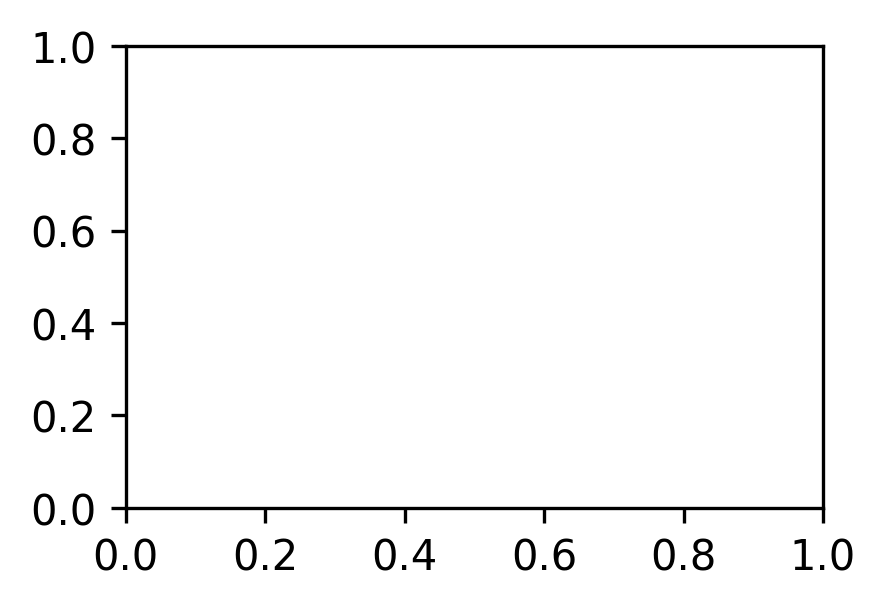

In [30]:

#sc.pl.pca(myoc_genes.concatenate([myoc_genes]), color="Species", show=False)


xlim, ylim = (-1, 3), (-1.25, 0.5)


fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(3, 2), frameon=False, dpi=300)

markers = {'a2m':"s", 'a2ml1':"^", 'myoc':"o"}

spec5_subset = myoc_genes[myoc_genes.obs["species"].isin(["human", "mouse", "pig", "macaca_fascicularis", "macaca_mulatta"])]

colors = {"human":"#1f77b4", "mouse":"#d62728", "pig":"#9467bd", "macaca_fascicularis":"#ff7f0e", "macaca_mulatta":"#2ca02c"}
for gene in spec5_subset.obs["genes"].unique():
    gene_subset = spec5_subset[spec5_subset.obs["genes"] == gene]
    X = gene_subset.obsm["X_pca"][:, 0]
    Y = gene_subset.obsm["X_pca"][:, 1]
    specs = list(gene_subset.obs["species"])
    ax.scatter(x=X, y=Y, marker=markers[gene], c=[colors[s] for s in specs]);
    #ax = sc.pl.pca(gene_subset, color="species", show=False, alpha=1, ax=ax, legend_fontsize=5, 
    #                legend_fontoutline=2, size=150
    #              )


#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

#ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    #a.set_text("\n".join(a._text.title().split()))
    a.set_text(a._text.replace("_", " ").title())
    
    #if a._text == 'Macrophage':
    #    a.set_text("3")
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False) 

print(plt.xlim(), plt.ylim())
plt.savefig("figures/4f_pca.svg")
plt.show();


In [31]:
all_caps_gene_to_scores = {k.upper():v for k,v in genes_to_scores.items()}
for g in spec5_subset.obs["gene_names"]:
    try:
        de = np.argmax(all_caps_gene_to_scores[g.upper()])
        print(f"{g} to {de}")
    except:
        print(f"Error on {g}")

human_a2m to 405
human_a2ml1 to 1375
human_myoc to 405
mouse_a2m to 1375
Error on mouse_a2ml1
mouse_myoc to 664
pig_a2m to 1375
Error on pig_a2ml1
pig_myoc to 664
macaca_fascicularis_a2ml1 to 1375
macaca_fascicularis_myoc to 664
Error on macaca_mulatta_a2ml1
macaca_mulatta_myoc to 664


In [ ]:
ancs_ad_all = sc.AnnData(ad.obsm["ancs"])
ancs_ad_all.obsm = ad.obsm
ancs_ad_all.obs = ad.obs

In [32]:
np.argmax(genes_to_scores["pig_MYOC"])

664

In [33]:
np.argmax(genes_to_scores["human_MYOC"])

405

In [ ]:
#sc.tl.dendrogram(ancs_ad, groupby='labels', use_rep='X')
#subset_1_ad.uns["dendrogram_labels2"] = subset_1_ad_embs.uns["dendrogram_labels2"]
pig_myoc = np.argmax(genes_to_scores["pig_MYOC"])
human_myoc = np.argmax(genes_to_scores["human_MYOC"])
#human_a2m = np.argmax(genes_to_scores["macaF_A2ML1"])
pig_a2m = np.argmax(genes_to_scores["pig_A2M"])

markers = [f'{pig_myoc}', f'{human_myoc}', f'{pig_a2m}' ] #de_df_pos.head(5)["names"].astype(str)

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
dp = sc.pl.dotplot(ancs_ad, markers, groupby='species', dendrogram=False, show=False, cmap="viridis", ax=ax, vmin=0.0, vmax=5, dot_min=0, dot_max=1)

#dp["mainplot_ax"].set_xticklabels(["Arhgdi", "Ptp", "Parv", "Tmem", "Ssr"], rotation = 0, ha="center")
dp["mainplot_ax"].set_xticklabels([f"Macrogene {pig_myoc}\nNon Human Myoc", 
                                   f"Macrogene {human_myoc}\nHuman Myoc/A2m ",
                                   #f"Macrogene {human_a2m}\nHuman A2M ", 
                                   f"Macrogene {pig_atm}\nNon Human A2m"], rotation = 90, ha="center")
dp["mainplot_ax"].set_yticklabels([a.get_text().replace("_", " ").title() for a in dp["mainplot_ax"].get_yticklabels()])

plt.savefig("figures/4d_dot.svg")

In [ ]:
ad_non_subset = ad[(~(ad.obs["coarse"].isin(keep_cells)) | (ad.obs["labels2"] == "Corneal endothelium"))]
ad_non_subset_anc = sc.AnnData(ad_non_subset.obsm["ancs"])
ad_non_subset_anc.obs = ad_non_subset.obs
ad_non_subset_anc

In [ ]:
genes_to_scores

In [ ]:
pig_myoc = np.argmax(genes_to_scores["pig_MYOC"])
human_myoc = np.argmax(genes_to_scores["human_MYOC"])
#human_a2m = np.argmax(genes_to_scores["macaF_A2ML1"])
pig_a2m = np.argmax(genes_to_scores["pig_A2M"])

markers = [f'{pig_myoc}', f'{human_myoc}', f'{pig_a2m}' ] #de_df_pos.head(5)["names"].astype(str)

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
dp = sc.pl.dotplot(ad_non_subset_anc, markers, groupby='species', dendrogram=False, show=False, cmap="viridis", ax=ax, vmin=0.0, vmax=5, dot_min=0, dot_max=1, )

#dp["mainplot_ax"].set_xticklabels(["Arhgdi", "Ptp", "Parv", "Tmem", "Ssr"], rotation = 0, ha="center")
dp["mainplot_ax"].set_xticklabels([f"Macrogene {pig_myoc}\nNon Human Myoc", 
                                   f"Macrogene {human_myoc}\nHuman Myoc/A2m ",
                                   #f"Macrogene {human_a2m}\nHuman A2M ", 
                                   f"Macrogene {pig_atm}\nNon Human A2m"], rotation = 90, ha="center")
dp["mainplot_ax"].set_yticklabels([a.get_text().replace("_", " ").title() for a in dp["mainplot_ax"].get_yticklabels()])

#plt.savefig("figures/4d_dot.svg")

In [ ]:
import seaborn as sns
#fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(4, 2.25), frameon=False, dpi=300)
ax = sns.clustermap(new_df, cmap="viridis"); 
plt.savefig("figures/4b_heatmap.svg")    
plt.show()

In [34]:
de = np.argmax(genes_to_scores["mouse_Myoc"])
print(de)
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

664


,gene,weight
8480,macaca_fascicularis_MYOC,1.394169
24410,mouse_Myoc,1.305283
16770,macaca_mulatta_MYOC,1.117631
406,human_OLFML3,1.027965
35951,pig_MYOC,1.011485
8641,macaca_fascicularis_OLFML3,0.905605
32256,pig_GLDN,0.902806
4185,human_OLFML2A,0.896836
32643,pig_OLFML2A,0.870827
24450,mouse_Olfml2b,0.840055


In [52]:
ad

AnnData object with n_obs × n_vars = 50112 × 256
    obs: 'labels', 'labels2', 'ref_labels', 'species', 'coarse'
    obsm: 'ancs'

In [56]:
ad.obs[["species", "labels2"]].groupby("labels2").agg(lambda x: ','.join(x.unique()))

,species
labels2,
B cell,"macaca_fascicularis,mouse"
BCell,human
Beam A,"macaca_mulatta,mouse,pig"
Beam X,"macaca_fascicularis,macaca_mulatta"
Beam Y,mouse
BeamA,macaca_fascicularis
BeamCella,human
BeamCellb,human
Ciliary muscle,"macaca_fascicularis,macaca_mulatta,mouse,pig"


In [55]:
ad.obs[["species", "coarse", "labels2"]].groupby("coarse").agg(lambda x: len(x.unique()))

,species,labels2
coarse,,
Ciliary epithelium,1,3
Ciliary muscle,5,2
Collector channel,3,2
Corneal,4,4
Endothelium,1,1
Fibroblast,3,1
JCT,5,2
Macrophage,5,1
Mast,1,1


In [35]:
de = np.argmax(genes_to_scores["human_MYOC"])
print(de)
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

405


,gene,weight
27657,mouse_Folr1,1.673962
5999,human_B2M,1.418661
27080,mouse_Fbln2,1.408592
28014,mouse_Srgn,1.316776
632,human_MYOC,1.138967
26391,mouse_Sema3c,1.132521
26012,mouse_Lpar1,1.120726
31393,mouse_Adgrf5,0.885479
39103,pig_SCP2D1,0.813015
25867,mouse_Adgrl4,0.809624


In [36]:
de = np.argmax(genes_to_scores["human_A2M"])
print(de)
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

405


,gene,weight
27657,mouse_Folr1,1.673962
5999,human_B2M,1.418661
27080,mouse_Fbln2,1.408592
28014,mouse_Srgn,1.316776
632,human_MYOC,1.138967
26391,mouse_Sema3c,1.132521
26012,mouse_Lpar1,1.120726
31393,mouse_Adgrf5,0.885479
39103,pig_SCP2D1,0.813015
25867,mouse_Adgrl4,0.809624


In [37]:
de = np.argmax(genes_to_scores["pig_A2M"])
print(de)
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

1375


,gene,weight
23577,macaca_mulatta_C3,1.406938
27155,mouse_A2m,1.336448
38405,pig_A2M,1.059856
37706,pig_C4A,0.917377
31462,mouse_C3,0.902040
32193,pig_CD109,0.900841
34418,pig_C3,0.851106
20080,macaca_mulatta_PZP,0.828825
23668,macaca_mulatta_CPAMD8,0.820771
21657,macaca_mulatta_C5,0.815449


In [38]:
de = np.argmax(genes_to_scores["mouse_A2m"])
print(de)
max_gene = pd.DataFrame(get_scores(int(de)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(10)

1375


,gene,weight
23577,macaca_mulatta_C3,1.406938
27155,mouse_A2m,1.336448
38405,pig_A2M,1.059856
37706,pig_C4A,0.917377
31462,mouse_C3,0.902040
32193,pig_CD109,0.900841
34418,pig_C3,0.851106
20080,macaca_mulatta_PZP,0.828825
23668,macaca_mulatta_CPAMD8,0.820771
21657,macaca_mulatta_C5,0.815449


# Fibroblast Markers

Only considering the two last: ['.0_ESM2_seed_10', '.h5ad'].
Only considering the two last: ['.0_ESM2_seed_10', '.h5ad'].


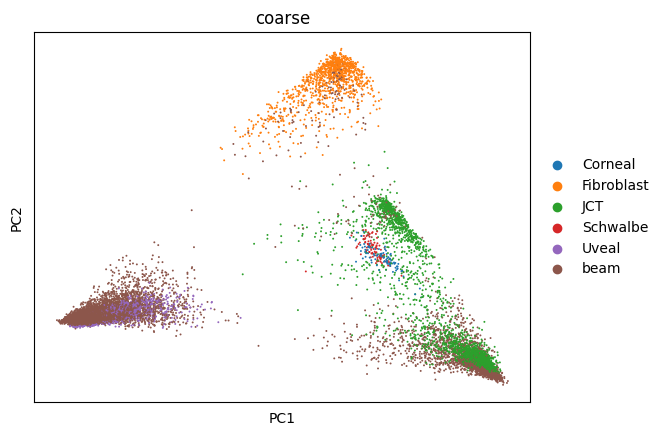


KeyboardInterrupt



In [13]:
cl_mapping = {
    "mouse_14_Beam A":"1",
    "mouse_9_Beam Y":"1",
    "pig_6_Fibroblast":"1",
    "human_Fibroblast":"1",
    "macaca_fascicularis_7_Fibroblast":"1",
    
    
    "macaca_mulatta_4_Beam A":"2",
    "mouse_1_Uveal":"2",
    "human_BeamCella":"2",
    "macaca_fascicularis_2_BeamA":"2",
    "pig_1_Beam A":"2",
    
    "human_BeamCellb":"3",
    "macaca_mulatta_1_Beam X":"3",
    "macaca_fascicularis_6_JCT":"3",
    "pig_3_JCT":"3",
    
    "macaca_fascicularis_15_Beam X":"4",
    "macaca_mulatta_10_JCT":"4",
    "human_CribiformJCT":"4",
    "mouse_6_JCT":"4",
    
    "pig_17_Corneal endothelium":"5",
    "human_SchwalbeLine":"5",
    "mouse_12_Corneal endothelium":"5",
    
}

keep_cells = ["beam", "Schwalbe", "JCT", "Fibroblast", "Uveal"]
h5 = h5s[5]

ad = sc.read(h5)
ad.obs["coarse"] = [map_labels[a] for a in ad.obs["labels2"]]

ad_subset_new = ad[(ad.obs["coarse"].isin(keep_cells)) | (ad.obs["labels2"] == "Corneal endothelium")]
sc.pp.pca(ad_subset_new)

sc.pl.pca(ad_subset_new, color="coarse")
sc.pp.neighbors(ad_subset_new)
sc.tl.umap(ad_subset_new)

In [ ]:
sc.pp.pca(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [ ]:
anc_ad = sc.AnnData(ad.obsm["ancs"])
anc_ad.obs = ad.obs
anc_ad.obsm = ad.obsm
anc_ad

In [ ]:
anc_ad.obs["recluster"] = [cl_mapping.get(l, "Other") for l in anc_ad.obs["labels"]]

In [ ]:
sc.pl.umap(anc_ad, color="recluster")
sc.pl.umap(anc_ad, color=)

In [14]:
import pickle
with open(h5.replace(".h5ad", "_genes_to_centroids.pkl"),'rb') as f:
    genes_to_scores = pickle.load(f)
def get_scores(anc_idx):
    '''
    Given the index of a centroid, return the scores by gene for that centroid
    '''
    scores = {}
    for (gene), embs in genes_to_scores.items():
        scores[gene] = embs[anc_idx]
    return scores

In [15]:
fbn1 = np.argmax(genes_to_scores["mouse_Fbn1"])
print(fbn1)
max_gene = pd.DataFrame(get_scores(int(fbn1)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(5)

1962


,gene,weight
5632,human_ITGBL1,0.924178
14863,macaca_fascicularis_FBN1,0.915157
24928,mouse_Fbn1,0.762170
11575,macaca_fascicularis_ITGBL1,0.750257
28984,mouse_Itgbl1,0.749282


In [ ]:
pi16 = np.argmax(genes_to_scores["mouse_Pi16"])
print(pi16)
max_gene = pd.DataFrame(get_scores(int(pi16)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(5)

In [ ]:
Mfap5 = np.argmax(genes_to_scores["mouse_Mfap5"])
print(Mfap5)
max_gene = pd.DataFrame(get_scores(int(Mfap5)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(5)

In [ ]:
Tnxb = np.argmax(genes_to_scores["mouse_Tnxb"])
print(Tnxb)
max_gene = pd.DataFrame(get_scores(int(Tnxb)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(5)

In [ ]:
Clec3b = np.argmax(genes_to_scores["mouse_Clec3b"])
print(Clec3b)
max_gene = pd.DataFrame(get_scores(int(Clec3b)).items(), columns=["gene", "weight"]).sort_values("weight", ascending=False)
max_gene.head(5)

In [ ]:
sc.pl.umap(anc_ad, color="recluster")
sc.pl.umap(anc_ad, color="species")
fibroblast_genes = {
    "Fbn1":fbn1,
    "Pi16":pi16,
    "Mfap5":Mfap5,
    "Tnxb":Tnxb,
    "Clec3b":Clec3b,
}

sc.pl.umap(anc_ad, color=[str(g) for g in fibroblast_genes.values()])

for g in fibroblast_genes:
    print(g)
    sc.pl.dotplot(anc_ad, var_names=[str(fibroblast_genes[g])], groupby="recluster", cmap="viridis")
    

# Biohub Poster

In [61]:
sc.pp.pca(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)

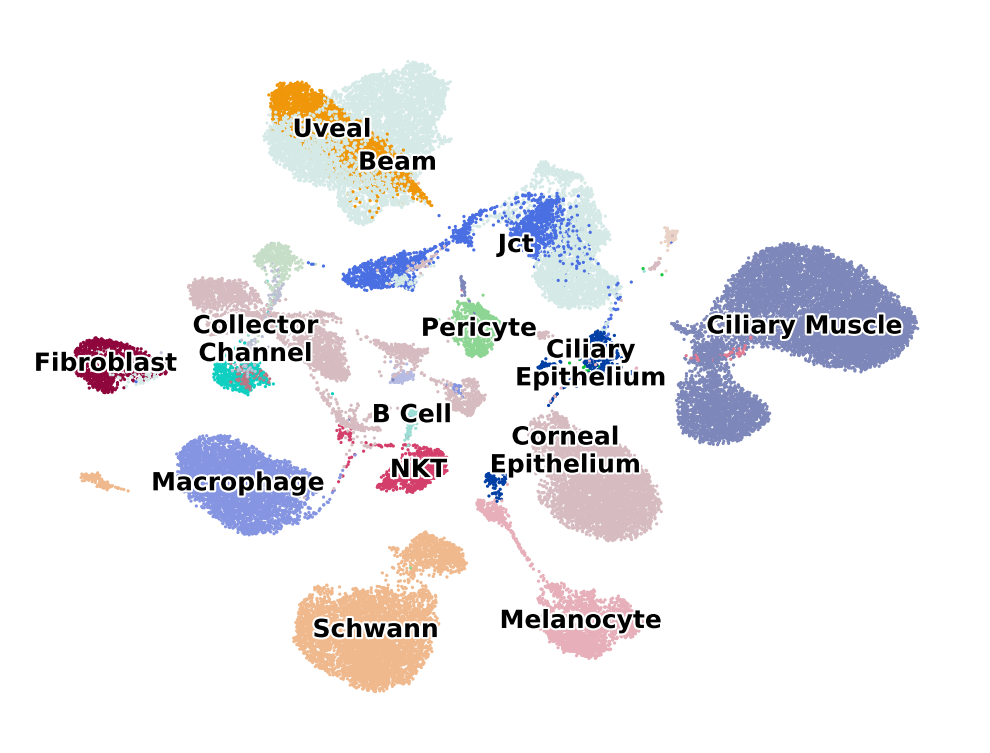

In [69]:
width = 4#9.3
height = 3#4.9
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(width, height), frameon=False, dpi=300)

not_to_show = ["Vascular", "Endothelium", "Schwalbe", 
               "Collector Channel", "Neuron", "Myoepithelium", 
               "Mast", "SC"]
ax = sc.pl.umap(ad, color="coarse", show=False, alpha=1, legend_loc='on data', ax=ax, legend_fontsize=6, legend_fontoutline=1)
ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    if (a._text in not_to_show):
        #print(a._text)
        a.set_visible(False)
    else:
        a.set_text(a._text.title())
    if a._text == 'Corneal':
        a.set_text("Corneal\nEpithelium")
    if a._text == 'Ciliary Epithelium':
        a.set_text("Ciliary\nEpithelium")
    if a._text == 'Collector Channel':
        a.set_text("Collector\nChannel")
    if a._text == 'Nkt':
        a.set_text("NKT")
    #if a._text == 'Macrophage':
    #    a.set_text("3")
    #a.set_fontsize(12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("figures/4a_main_poster.svg")    
plt.show()


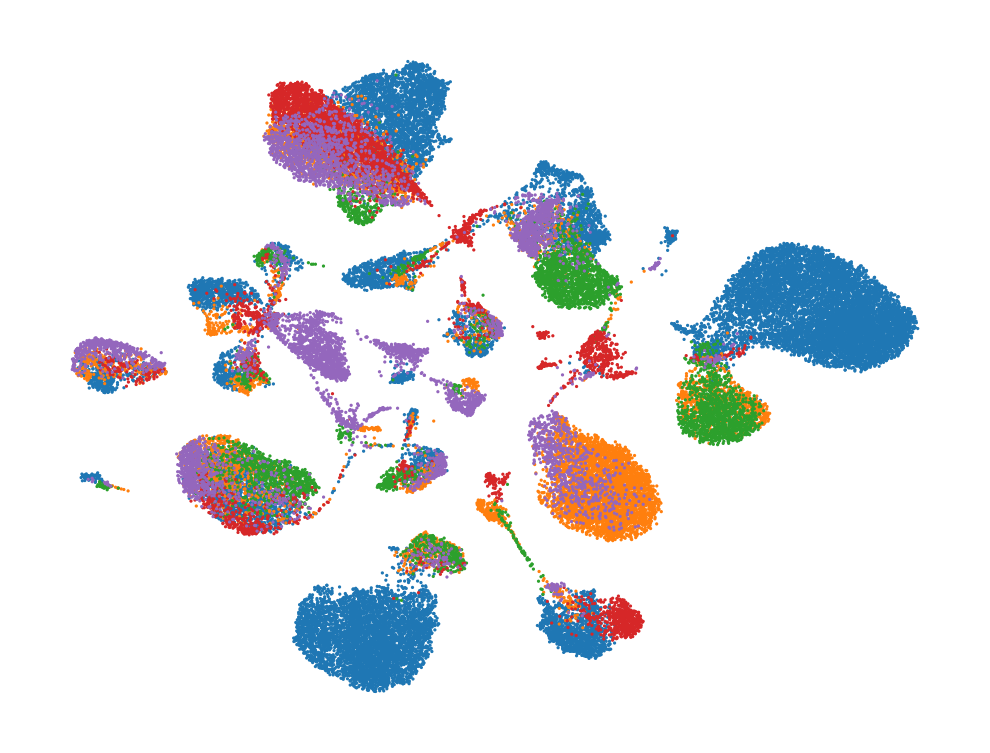

In [70]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize=(width, height), frameon=False, dpi=300)

not_to_show = ["Vascular", "Endothelium", "Schwalbe", 
               "Collector Channel", "Neuron", "Myoepithelium", 
               "Mast", "SC"]
ax = sc.pl.umap(ad, color="species", show=False, alpha=1, legend_loc=None, ax=ax, legend_fontsize=7, legend_fontoutline=2)
ax.set(xlabel=None, ylabel=None);
ax.set(title=None)
for a in ax.texts:
    if (a._text in not_to_show):
        #print(a._text)
        a.set_visible(False)
    if a._text == 'Spemann\nOrganizer':
        a.set_text("1")
    if a._text == 'Goblet\nCell':
        a.set_text("2")
    #a.set_text("\n".join(a._text.title().split()))
    #if a._text == 'Macrophage':
    #    a.set_text("3")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("figures/4a_spec_poster.svg")    
plt.show()


In [ ]:
myoc_genes